# Preamble

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import warn
import re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (balanced_accuracy_score, classification_report, 
                             roc_curve, roc_auc_score, precision_score,
                             RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier, plot_importance, to_graphviz

sns.set_style('ticks')

# ETL

In [138]:
_RAW_DATA_PATH_ = '../data/raw_data_from_kaggle.csv'

In [139]:
raw_data = pd.read_csv(_RAW_DATA_PATH_)

In [140]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [141]:
if 'customerID' in raw_data.columns:
    assert raw_data['customerID'].nunique() == raw_data.shape[0], "Data contains duplicate customerIDs"
    raw_data.drop(columns=['customerID'], inplace=True)

In [142]:
raw_data.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [143]:
for (a_col, a_type) in zip(raw_data.columns, raw_data.dtypes):
    if a_type == 'object':
        if raw_data[a_col].nunique() > 2:
            print(raw_data[a_col].value_counts())
            print()

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

Contract
Month-to-month    387

In [144]:
try:
    del raw_data
except NameError:
    print("Already deleted!")

## Standardizing Data

In [145]:
cleaned_data = pd.read_csv(_RAW_DATA_PATH_, 
                           na_values=' ', 
                           keep_default_na=True,
                           true_values=['Yes'], 
                           false_values=['No', 'No phone service', 'No internet service'])
cleaned_data.rename(columns={colName:colName[0].upper() + colName[1:] for colName in cleaned_data.columns if colName[0].islower()}, inplace=True)
cleaned_data.drop(columns='CustomerID', inplace=True)

In [146]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   bool   
 3   Dependents        7043 non-null   bool   
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   bool   
 6   MultipleLines     7043 non-null   bool   
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   bool   
 9   OnlineBackup      7043 non-null   bool   
 10  DeviceProtection  7043 non-null   bool   
 11  TechSupport       7043 non-null   bool   
 12  StreamingTV       7043 non-null   bool   
 13  StreamingMovies   7043 non-null   bool   
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   bool   
 16  PaymentMethod     7043 non-null   object 


In [147]:
cleaned_data['SeniorCitizen'] = cleaned_data['SeniorCitizen'].astype(bool)

In [148]:
nan_percent_threshold = 1.0
if (100.0*cleaned_data['TotalCharges'].isna().sum()/cleaned_data.shape[0] > nan_percent_threshold):
    warn(f"Number of NaN values is more than {nan_percent_threshold}% of the total data set. Be careful.", stacklevel=2)
cleaned_data.dropna(inplace=True)

In [149]:
total_charges_eq_monthly = cleaned_data['TotalCharges'] == cleaned_data['MonthlyCharges']

In [150]:
if cleaned_data[total_charges_eq_monthly]['Tenure'].unique() != 1:
    warn("Customers with Tenure longer than 1 month have TotalCharges == MonthlyCharges")


In [151]:
cleaned_data.to_csv("../data/cleaned_data.csv", index=False)

In [152]:
for (a_col, a_type) in zip(cleaned_data.columns, cleaned_data.dtypes):
    if a_type == 'object':
        if cleaned_data[a_col].nunique() >= 2:
            print(a_col, '->' ,cleaned_data[a_col].unique())

Gender -> ['Female' 'Male']
InternetService -> ['DSL' 'Fiber optic' 'No']
Contract -> ['Month-to-month' 'One year' 'Two year']
PaymentMethod -> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [153]:
def find_mappable_columns(in_df: pd.DataFrame) -> list[str]:
    mappable_cols = []
    for (a_col, a_type) in zip(in_df.columns, in_df.dtypes):
        if a_type == 'object':
            if in_df[a_col].nunique() >= 2:
                mappable_cols.append(a_col)
    return mappable_cols

In [154]:
def to_pascal_case(in_str: str) -> str:
    capped_parts = [sub_str[0].upper()+sub_str[1:] for sub_str in re.split(r'[ -]',in_str)]
    return "".join(capped_parts)

In [155]:
reformatted_data = cleaned_data.copy()

In [156]:
for a_col in find_mappable_columns(in_df=reformatted_data):
    reformatted_data[a_col] = reformatted_data[a_col].map(to_pascal_case)

In [157]:
for a_col in find_mappable_columns(in_df=reformatted_data):
    print(a_col, '->' , reformatted_data[a_col].unique())

Gender -> ['Female' 'Male']
InternetService -> ['DSL' 'FiberOptic' 'No']
Contract -> ['MonthToMonth' 'OneYear' 'TwoYear']
PaymentMethod -> ['ElectronicCheck' 'MailedCheck' 'BankTransfer(automatic)'
 'CreditCard(automatic)']


In [158]:
reformatted_data.dtypes

Gender               object
SeniorCitizen          bool
Partner                bool
Dependents             bool
Tenure                int64
PhoneService           bool
MultipleLines          bool
InternetService      object
OnlineSecurity         bool
OnlineBackup           bool
DeviceProtection       bool
TechSupport            bool
StreamingTV            bool
StreamingMovies        bool
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                  bool
dtype: object

In [159]:
reformatted_data.to_csv("../data/reformatted_cleaned_data.csv", index=False)

In [160]:
try:
    del reformatted_data
    del cleaned_data
except NameError:
    print("Already deleted!")

# EAD

In [232]:
full_ead_data = pd.read_csv("../data/reformatted_cleaned_data.csv", )
full_X = full_ead_data.copy()
full_y = full_X.pop('Churn')

In [233]:
encodable_columns = sorted([col for col in full_X.columns if full_X[col].dtype == 'object'])
boolean_columns = sorted([col for col in full_X.columns if full_X[col].dtype == 'bool'])
numeric_columns = sorted(list({*list(full_X.columns)} ^ {*encodable_columns} ^ {*boolean_columns}))

assert sorted(list(full_X.columns)) == sorted(list({*encodable_columns}|{*boolean_columns}|{*numeric_columns}))

print(encodable_columns)
print(boolean_columns)
print(numeric_columns)

['Contract', 'Gender', 'InternetService', 'PaymentMethod']
['Dependents', 'DeviceProtection', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport']
['MonthlyCharges', 'Tenure', 'TotalCharges']


In [234]:
full_X[encodable_columns] = full_X[encodable_columns].astype('category')

In [235]:
one_hot_enc = OneHotEncoder(sparse_output=False, )
one_hot_enc.fit(full_X[encodable_columns])
_tmp_OH_df = pd.DataFrame(data=one_hot_enc.transform(full_X[encodable_columns]), 
                          columns=one_hot_enc.get_feature_names_out(), dtype=bool)
OH_enc_full_X = pd.concat([full_X[list({*boolean_columns}|{*numeric_columns})],
                           _tmp_OH_df], axis=1)

In [236]:
_feat_mi_vals = mutual_info_classif(X=OH_enc_full_X, 
                                    y=full_y, 
                                    discrete_features=list(OH_enc_full_X.dtypes == 'bool'))
feature_mutual_info = pd.Series(_feat_mi_vals, index=OH_enc_full_X.columns)
feature_mutual_info = feature_mutual_info.sort_values(ascending=False, inplace=False)
feature_mutual_info

Contract_MonthToMonth                    0.091657
Tenure                                   0.072956
Contract_TwoYear                         0.060289
MonthlyCharges                           0.052573
InternetService_FiberOptic               0.047646
PaymentMethod_ElectronicCheck            0.043800
TotalCharges                             0.043055
InternetService_No                       0.031274
PaperlessBilling                         0.019119
Contract_OneYear                         0.018145
OnlineSecurity                           0.015891
TechSupport                              0.014614
Dependents                               0.014270
Partner                                  0.011383
SeniorCitizen                            0.010533
PaymentMethod_CreditCard(automatic)      0.009890
InternetService_DSL                      0.007999
PaymentMethod_BankTransfer(automatic)    0.007498
PaymentMethod_MailedCheck                0.004329
OnlineBackup                             0.003464


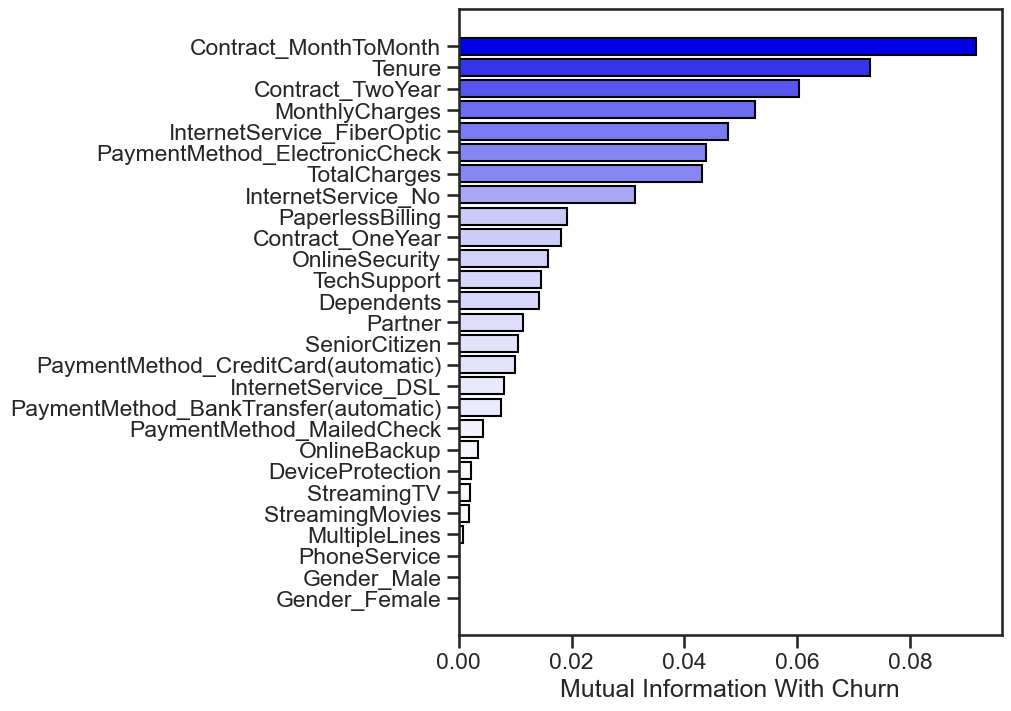

In [237]:
feature_mutual_info.sort_values(ascending=True, inplace=True)
_vals = feature_mutual_info.to_numpy()
_colors = [(0.0, 0.0, 0.9, a_val) for a_val in _vals/np.max(_vals)]
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[10,7], sharey=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    fAx[0].barh(feature_mutual_info.index, _vals, ec='k', color=_colors)
    fAx[0].set_xlabel('Mutual Information With Churn')
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.savefig("../reports/churn_mutual_information.png", bbox_inches='tight')
    plt.show()

feature_mutual_info.sort_values(ascending=False, inplace=True)

In [169]:
top_mi_categories = set([a_feature.split('_')[0] for a_feature in feature_mutual_info.index[:4]])
top_mi_categories

{'Contract', 'InternetService', 'Tenure'}

Churn            False   True    All
InternetService                     
DSL              0.278  0.065  0.344
FiberOptic       0.256  0.184  0.440
No               0.200  0.016  0.216
All              0.734  0.266  1.000

Churn         False   True    All
Contract                         
MonthToMonth  0.316  0.235  0.551
OneYear       0.186  0.024  0.209
TwoYear       0.233  0.007  0.240
All           0.734  0.266  1.000



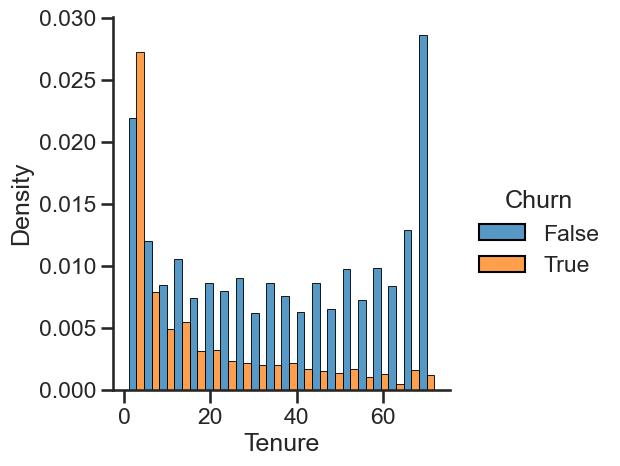

In [170]:
for a_feature in top_mi_categories:
    if (a_feature in encodable_columns + boolean_columns):
        print(round(pd.crosstab(full_X[a_feature], full_y, margins=True, normalize=True), 3))
        print()
    if a_feature in numeric_columns:
        with sns.plotting_context('talk'):
            sns.displot(data=full_ead_data, x=a_feature, 
                        hue='Churn', bins=20, 
                        multiple='dodge', stat='density', ec='k')
            plt.show()

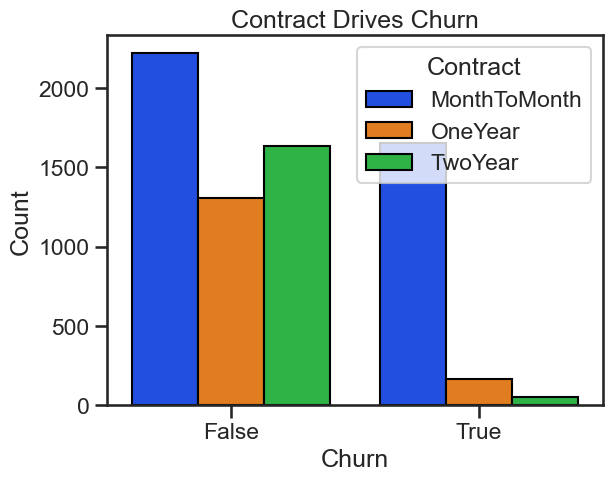

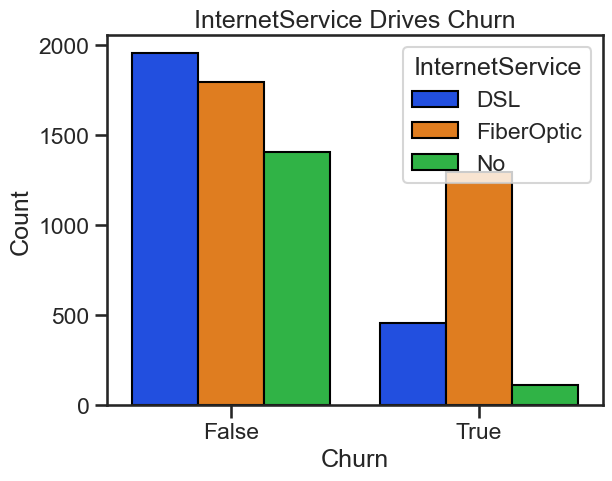

In [301]:
with sns.plotting_context('talk'):
    for feature in ['Contract', 'InternetService']:
        sns.countplot(data=full_ead_data, x='Churn', 
                      hue=feature, ec='k', palette='bright')
        plt.title(f"{feature} Drives Churn")
        plt.ylabel("Count")
        plt.savefig(f"../reports/ead_barchart_{feature.lower()}.png", 
                   bbox_inches='tight')
        plt.show()

In [203]:
bottom_mi_categories = set([a_feature.split('_')[0] for a_feature in feature_mutual_info.index[-4:]])
bottom_mi_categories

{'Gender', 'MultipleLines', 'PhoneService'}

# Model Training

## Logistic Regression

In [302]:
DROP_LOWEST_MI_FEATURES = False
if DROP_LOWEST_MI_FEATURES:
    X_train, X_valid, y_train, y_valid = train_test_split(full_X.drop(columns=list(bottom_mi_categories)), full_y, test_size=0.40, random_state=10)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(full_X, full_y, test_size=0.40, random_state=10)
X_train.shape

(4219, 19)

In [303]:
encodable_columns = sorted([col for col in X_train.columns if X_train[col].dtype == 'category'])
boolean_columns = sorted([col for col in X_train.columns if X_train[col].dtype == 'bool'])
numeric_columns = sorted(list({*list(X_train.columns)} ^ {*encodable_columns} ^ {*boolean_columns}))

assert sorted(list(X_train.columns)) == sorted(list({*encodable_columns}|{*boolean_columns}|{*numeric_columns}))

print(encodable_columns)
print(boolean_columns)
print(numeric_columns)

['Contract', 'Gender', 'InternetService', 'PaymentMethod']
['Dependents', 'DeviceProtection', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport']
['MonthlyCharges', 'Tenure', 'TotalCharges']


In [304]:
categorical_transformer = Pipeline(steps=[('onehot', 
                                           OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
numeric_transformer = Pipeline(steps=[('scale', 
                                       QuantileTransformer(output_distribution='normal'))])
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_columns),
                                               ('categorical', categorical_transformer, encodable_columns)], 
                                 remainder='passthrough')

logisticCV_model = LogisticRegressionCV(Cs=10, cv=5, solver='liblinear', max_iter=2000, random_state=10, 
                                        scoring='balanced_accuracy', class_weight='balanced', penalty='l2')
logisticCV_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', logisticCV_model)])
logisticCV_pipeline.fit(X_train, y_train)
logisticCV_predictions = logisticCV_pipeline.predict(X_valid)
logisticCV_prob_predictions = logisticCV_pipeline.predict_proba(X_valid)[:,1]
print("Balanced accuracy", f"{balanced_accuracy_score(y_true=y_valid, y_pred=logisticCV_predictions):.4f}")
print("ROC-AUC", f"{roc_auc_score(y_true=y_valid, y_score=logisticCV_predictions):.4f}")

Balanced accuracy 0.7766
ROC-AUC 0.7766


## XGBoost Classifier

In [305]:
full_ead_data.shape

(7032, 20)

In [306]:
xgb_model = XGBClassifier(n_estimators=500, early_stopping_rounds=10, 
                          enable_categorical=True, scale_pos_weight=np.sum(~y_train)/np.sum(y_train),
                          objective='binary:logistic', tree_method='approx',
                          learning_rate=0.05, eta=0.005, subsample=0.5, random_state=10)
xgb_model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=False, 
              )
xgb_predictions = xgb_model.predict(X_valid)
xgb_prob_predictions = xgb_model.predict_proba(X_valid)[:,1]
print("Balanced accuracy", f"{balanced_accuracy_score(y_true=y_valid, y_pred=xgb_predictions):.4f}")
print("ROC-AUC", f"{roc_auc_score(y_true=y_valid, y_score=xgb_predictions):.4f}")

Balanced accuracy 0.7562
ROC-AUC 0.7562


# Model Evaluation

## Logistic Regression

In [307]:
print(classification_report(y_true=y_valid, y_pred=logisticCV_predictions))

              precision    recall  f1-score   support

       False       0.92      0.72      0.81      2075
        True       0.51      0.84      0.64       738

    accuracy                           0.75      2813
   macro avg       0.72      0.78      0.72      2813
weighted avg       0.82      0.75      0.76      2813



## XGBoost Classifier

In [308]:
print(classification_report(y_true=y_valid, y_pred=xgb_predictions))

              precision    recall  f1-score   support

       False       0.90      0.75      0.82      2075
        True       0.52      0.76      0.62       738

    accuracy                           0.75      2813
   macro avg       0.71      0.76      0.72      2813
weighted avg       0.80      0.75      0.77      2813



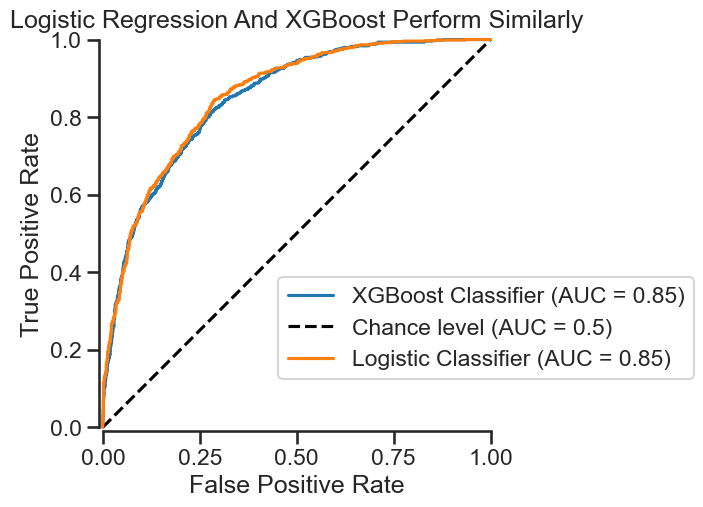

In [309]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[5,5], sharey=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    RocCurveDisplay.from_predictions(y_true=y_valid.to_numpy().ravel(), 
                                     y_score=xgb_prob_predictions, 
                                     plot_chance_level=True,
                                     ax=fAx[0],
                                     name=f'XGBoost Classifier')
    RocCurveDisplay.from_predictions(y_true=y_valid.to_numpy().ravel(), 
                                     y_score=logisticCV_prob_predictions, 
                                     plot_chance_level=False,
                                     ax=fAx[0],
                                     name=f'Logistic Classifier', despine=True)
    fAx[0].get_legend().remove()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(0.5, 0.35), loc='center left')
    plt.title("Logistic Regression And XGBoost Perform Similarly")
    plt.savefig("../reports/roc_curves.png", bbox_inches='tight')
    plt.show()

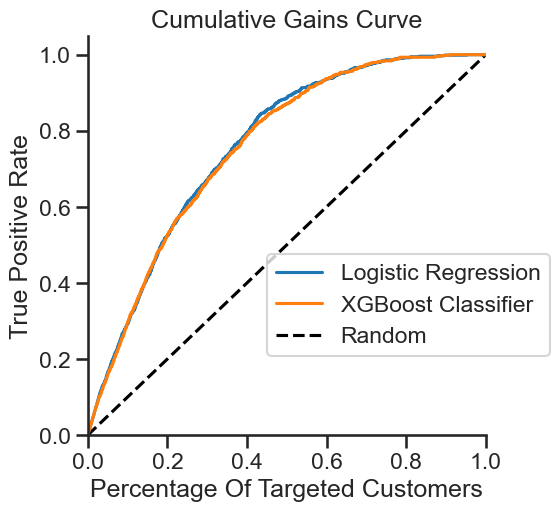

In [310]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[5,5], constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    for model_probs, model_label in zip([logisticCV_prob_predictions, xgb_prob_predictions], 
                                        ['Logistic Regression', 'XGBoost Classifier']):
        _fpr, _tpr, _thresh = roc_curve(y_true=y_valid, y_score=model_probs)
        pop_targeted = np.asarray([np.mean(model_probs >= thresh) for thresh in _thresh])
        fAx[0].plot(pop_targeted, _tpr, '-', label=model_label, mec='k')
    plt.plot([0,1],[0,1], label='Random', color='k', ls='--', zorder=0)
    plt.xlim(0,1)
    plt.ylim(0,None)
    plt.ylabel("True Positive Rate")
    plt.xlabel("Percentage Of Targeted Customers")
    plt.title("Cumulative Gains Curve")
    sns.despine()
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(0.5, 0.4), loc='center left')
    plt.show()

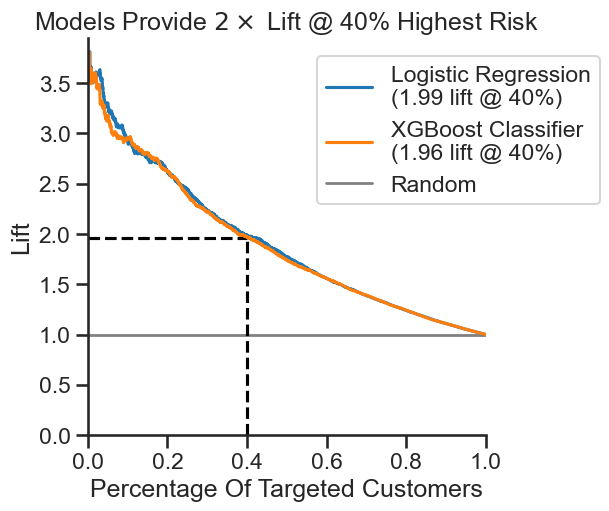

In [311]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[5,5], constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    for model_probs, model_label in zip([logisticCV_prob_predictions, xgb_prob_predictions], 
                                        ['Logistic Regression', 'XGBoost Classifier']):
        _fpr, _tpr, _thresh = roc_curve(y_true=y_valid, y_score=model_probs)
        pop_targeted = np.asarray([np.mean(model_probs >= thresh) for thresh in _thresh])
        xAr = pop_targeted[1:]
        yAr = _tpr[1:]/pop_targeted[1:]
        liftAtMaxProf = yAr[xAr >= 0.40][0]
        fAx[0].plot(xAr, yAr, '-', 
                    label=f"{model_label}\n({liftAtMaxProf:.2f} lift @ 40%)", mec='k')
    plt.axhline(1, color='gray', zorder=0, lw=2, label='Random', ls='-')
    plt.axvline(0.4, color='black', ls='--', zorder=0, ymax=liftAtMaxProf/fAx[0].get_ylim()[1])
    plt.axhline(liftAtMaxProf, color='black', ls='--', zorder=0, xmax=0.4)
    plt.xlim(0,1)
    plt.ylim(0,None)
    plt.ylabel("Lift")
    plt.xlabel("Percentage Of Targeted Customers")
    sns.despine()
    plt.title(r"Models Provide $2\times$ Lift @ 40% Highest Risk")
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(0.6, 0.75), loc='center left')
    plt.savefig("../reports/lift_curves.png", bbox_inches='tight')
    plt.show()

# Churn Insights

## Logistic Regression

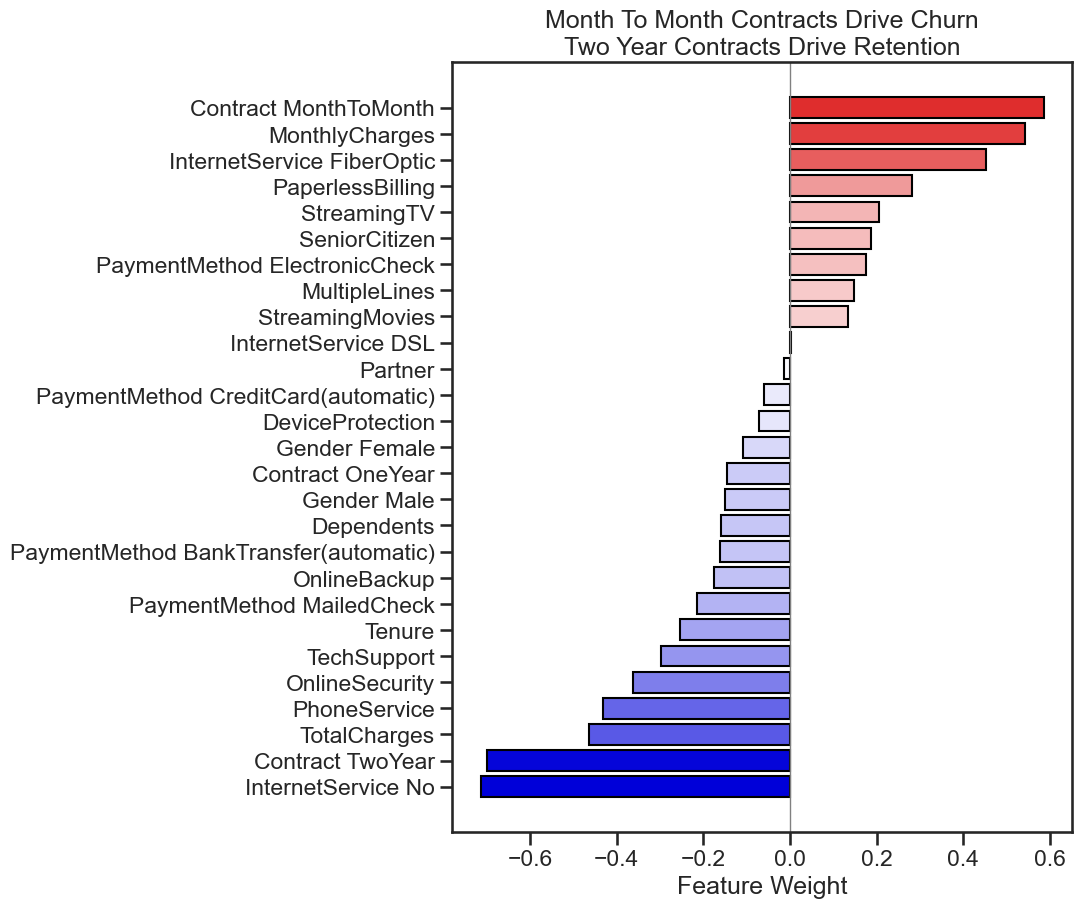

In [312]:
out_feature_names = np.asarray(list(map(lambda x: x.split('__')[-1].replace('_', ' '), logisticCV_pipeline[:-1].get_feature_names_out())))
out_feature_wts   = logisticCV_pipeline[-1].coef_[0]
_mx_wt = np.abs(out_feature_wts).max()
_wts_sort_idx = np.argsort(out_feature_wts)
_colors_list = np.asarray([(0.85 if wt >= 0 else 0.0, 0.0, 0.0 if wt >= 0 else 0.85, abs(wt)/_mx_wt) for wt in out_feature_wts])

with sns.plotting_context('talk'):
    plt.figure(figsize=(8,10))
    plt.barh(out_feature_names[_wts_sort_idx], 
             out_feature_wts[_wts_sort_idx], 
             color=_colors_list[_wts_sort_idx], ec='k')
    plt.axvline(0, color='gray', lw=1)
    plt.xlabel("Feature Weight")
    plt.title("Month To Month Contracts Drive Churn\nTwo Year Contracts Drive Retention")
    plt.savefig("../reports/logistic_feature_weights.png", bbox_inches='tight')
    plt.show()


## XGBoost Classifier

In [313]:
# to_graphviz(xgb_model,  rankdir='LR', with_stats=False,
#             condition_node_params={'shape':'box', 'style':'filled,rounded', 'fillcolor':'#78bceb'}, 
#             leaf_node_params={'shape':'box', 'style':'filled', 'fillcolor':'#e48038'}, )
    

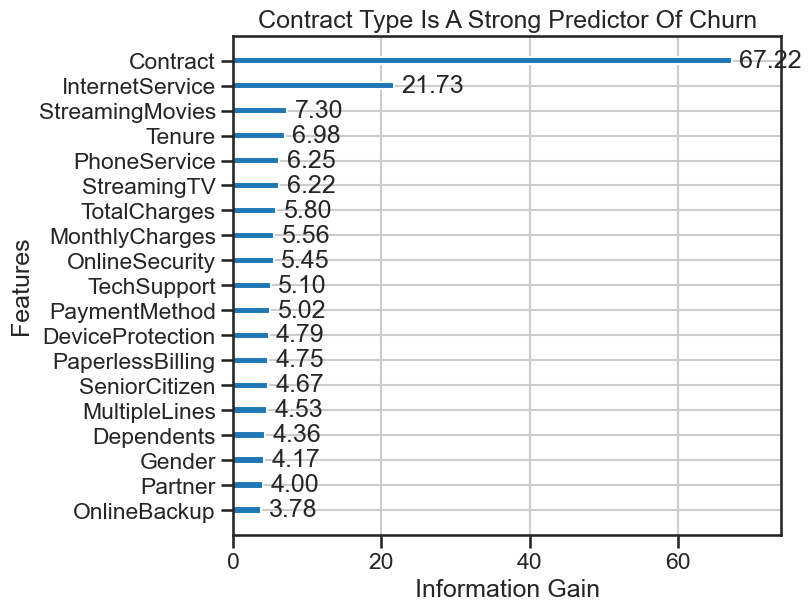

In [314]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[8,6], sharey=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    plot_importance(xgb_model, importance_type='gain', ax=fAx[0],
                    values_format='{v:.2f}', xlabel='Information Gain', height=0.3, 
                    title='Contract Type Is A Strong Predictor Of Churn')
    plt.savefig("../reports/xgboost_gain.png", bbox_inches='tight')
    plt.show()

# ROI Simulations

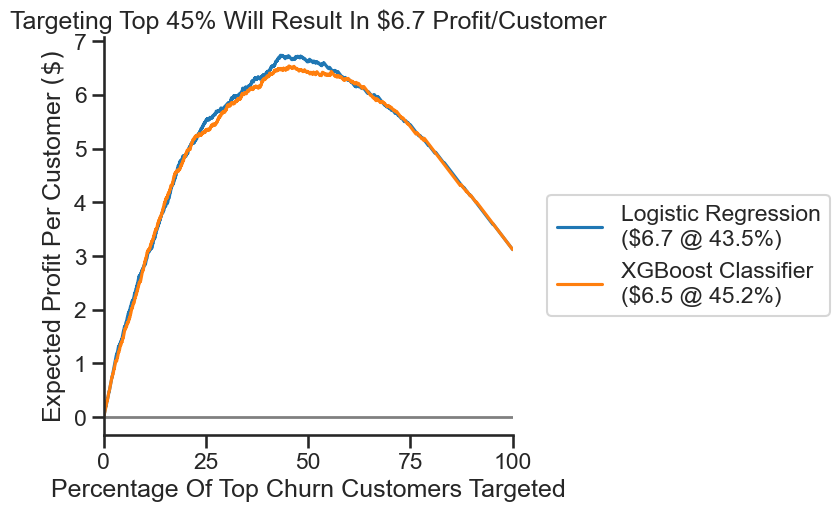

In [316]:
_revenuePerCustomer = 50;
_responseRate = 1.0;
_costPerCustomer = 10
_pChurn = np.mean(y_valid)

with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[5,5], constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    for model_probs, model_label in zip([logisticCV_prob_predictions, xgb_prob_predictions], 
                                        ['Logistic Regression', 'XGBoost Classifier']):
        _fpr, _tpr, _thresh = roc_curve(y_true=y_valid, y_score=model_probs, drop_intermediate=False)
        _profCurve = (_pChurn*_tpr*(_revenuePerCustomer*_responseRate - _costPerCustomer)
                 - (1.0-_pChurn)*_costPerCustomer*_fpr)
        pop_targeted = 100.0*np.asarray([np.mean(model_probs >= thresh) for thresh in _thresh])
        _maxProf = _profCurve[np.argmax(_profCurve)]
        _maxTgt  = pop_targeted[np.argmax(_profCurve)]
        fAx[0].plot(pop_targeted, _profCurve, label=f"{model_label}\n(\${_maxProf:.1f} @ {_maxTgt:.1f}%)")
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.xlim(0,100)
    plt.xticks(np.arange(0,110,25))
    plt.ylabel("Expected Profit Per Customer $(\$)$")
    plt.xlabel("Percentage Of Top Churn Customers Targeted")
    plt.axhline(0, color='gray', zorder=0, lw=2)
    sns.despine()
    plt.title("Targeting Top 45% Will Result In $6.7 Profit/Customer")
    plt.savefig("../reports/profit_curve.png", bbox_inches='tight')
    plt.show()

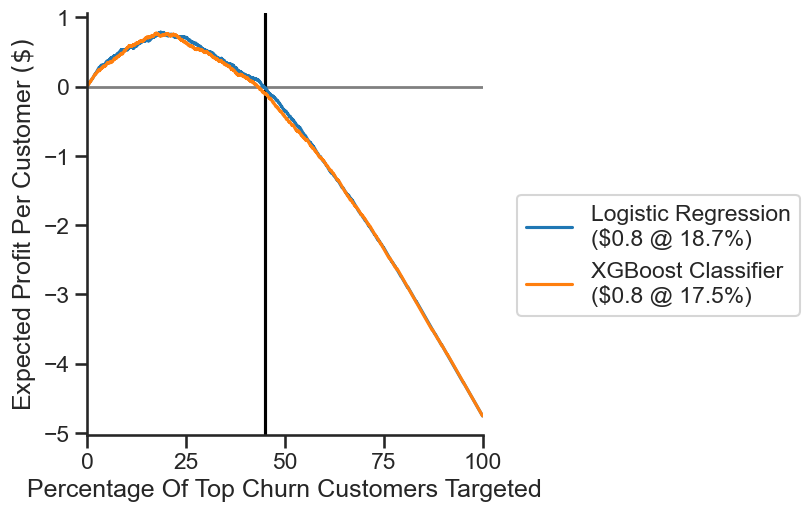

In [324]:
_revenuePerCustomer = 50;
_responseRate = 0.4;
_costPerCustomer = 10
_pChurn = np.mean(y_valid)

with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(1,1, figsize=[5,5], constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    for model_probs, model_label in zip([logisticCV_prob_predictions, xgb_prob_predictions], 
                                        ['Logistic Regression', 'XGBoost Classifier']):
        _fpr, _tpr, _thresh = roc_curve(y_true=y_valid, y_score=model_probs, drop_intermediate=False)
        _profCurve = (_pChurn*_tpr*(_revenuePerCustomer*_responseRate - _costPerCustomer)
                 - (1.0-_pChurn)*_costPerCustomer*_fpr)
        pop_targeted = 100.0*np.asarray([np.mean(model_probs >= thresh) for thresh in _thresh])
        _maxProf = _profCurve[np.argmax(_profCurve)]
        _maxTgt  = pop_targeted[np.argmax(_profCurve)]
        fAx[0].plot(pop_targeted, _profCurve, label=f"{model_label}\n(\${_maxProf:.1f} @ {_maxTgt:.1f}%)")
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.xlim(0,100)
    plt.xticks(np.arange(0,110,25))
    plt.ylabel("Expected Profit Per Customer $(\$)$")
    plt.xlabel("Percentage Of Top Churn Customers Targeted")
    plt.axhline(0, color='gray', zorder=0, lw=2)
    plt.axvline(0.45*100, color='k', zorder=0)
    sns.despine()
    plt.savefig("../reports/profit_curve_loresponse.png", bbox_inches='tight')
    plt.show()